# BEA Input-Output Use Tables

Concepts:

- ## Network Science, Centrality

- ## Industry links, Lead-lag cross momentum


Author: Terence Lim

References:

- https://www.sci.unich.it/~francesc/teaching/network/ 

- Choi and Foerster, 2017, "The Changing Input-Output Network Structure of the U.S. Economy", Federal Reserve Bank of Kansas City 

- Menzly, Lior, and Oguzhan Ozbas, 2010, Market segmentation and cross-predictability of returns, Journal of Finance 65, 1555–1580.

In [1]:
%matplotlib inline
import dives
import dives.dbengines
import dives.econs
import dives.util
import dives.structured
import dives.evaluate
import networkx as nx
import networkx.algorithms                                                 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
from pprint import pprint
from dives.util import DataFrame, NamedDict, sort_values, graph_calc, graph_draw
from dives.econs import Sectoring, BEA
from dives.dbengines import SQL, Redis
from dives.structured import BusDates, Benchmarks, CRSP, Signals
from dives.evaluate import BackTest, run_backtest

import secret   # passwords etc
sql = SQL(**secret.value('sql'))
rdb = Redis(**secret.value('redis'))
bea = BEA(**secret.value('bea'), rdb=rdb)
bd = BusDates(sql)
signals = Signals(sql)
bench = Benchmarks(sql, bd)
crsp = CRSP(sql, bd, rdb)
backtest = BackTest(sql, bench, 'RF')

dives/__init__ : from dives import ... [SUCCESS]


### Grab all years ioUse table from BEA website, and transform by vintage sectoring schemes

In [2]:
    ioUses = NamedDict(['vintage','year'])
    years = np.arange(1947, 2019) #[1947, 1963, 1997, 2018]                                                  
    vintages = [1947, 1963, 1997]
    for year in years:
        for vintage in [v for v in vintages if v <= year]:
            df = ioUse=bea.load_ioUse(year, vintage=vintage)
            ioUses.replace(vintage=vintage, year=year, ioUse=df)
            print('{} (scheme {}) n={}'.format(year, vintage, len(df)))



### helper function to sum ioUse flows by industry

In [3]:
    def ioUse_sum(ioUse, drop = ('F','T','U','V','Other'), by='rowcode',
                  exclude_self=True, get_label=bea.get_label):
        """return networkx DiGraph instance with directed edges from table                                   
                                                                                                             
        Parameters                                                                                           
        ----------                                                                                           
        ioUse : DataFrame                                                                                    
            stacked flows in column ['datavalue'], maker industry in ['rowcode'], user in ['colcode']        
        drop : list of str, optional (default is ('F','T','U','V','Other'))                                  
            do not sum over these industries                                                                 
        head : string, optional (default is 'rowcode')                                                       
            directed edge head ends at this column: 'rowcode' (default) for maker                            
        tail : string, optional (default is 'colcode')                                                       
            directed edge tail starts from this column: 'colcode' (default) for user                         
        normalize : string, optional (default is None):                                                      
            column name to sum by as denominator to normalize flows:                                         
        exclude_self : bool, optional (default True)                                                         
            whether to exclude self-flows in sum                                                             
        get_label : function, optional (default is bea.get_label)                                            
            function that returns node label name, set to None to use original codes                         
        """
        data = ioUse[(~ioUse['colcode'].str.startswith(drop) &
                      ~ioUse['rowcode'].str.startswith(drop))]       # codes to drop                         
        if exclude_self:                                             # exclude self loops                    
            data = data[(data['rowcode'] != data['colcode'])]
        df = pd.Series(data.groupby([by])['datavalue'].sum())      # total sum by industry                   
        if get_label:
            df.index = [get_label(x) for x in df.index]
        return df
                  


### Helper function convert ioUse flows to directed networkx graph
```

In [4]:
    def ioUse_graph(ioUse, drop = ('F','T','U','V','Other'), head = 'rowcode', tail = 'colcode',
                    get_label = bea.get_label, exclude_self = True, normalize  = None):
        """total flows by user- or maker-industry                                                            
                                                                                                             
        Parameters                                                                                           
        ----------                                                                                           
        ioUse : DataFrame                                                                                    
            stacked flows in column ['datavalue'], maker industry in ['rowcode'], user in ['colcode']        
        drop : list of str, optional (default is ('F','T','U','V','Other'))                                  
            do not sum over industry codes starting with these strings                                       
        by : string, optional (default 'rowcode')                                                            
            'rowcode' (default) to sum by maker industry. 'colcode' ro sum by user industry                  
        exclude_self : bool, optional (default True)                                                         
            whether to exclude self-flows in sum                                                             
        get_label : function, optional (default is bea.get_label)                                            
            function that returns node label name, set to None to use original codes                         
        """
        data = ioUse[(~ioUse[tail].str.startswith(drop) &
                      ~ioUse[head].str.startswith(drop))].copy()  # drop these industries                    
        if exclude_self:                                          # exclude self loops                       
            data = data[(data[tail] != data[head])]
        if normalize:
            group = data.groupby([normalize])
            data['weights'] = data['datavalue'] / group['datavalue'].transform('sum')
        else:
            data['weights'] = data['datavalue'] / data['datavalue'].sum()
        if get_label is None:
            get_label = lambda x : x
        edges = [(get_label(c), get_label(r), w) for c,r,w in data[[tail, head, 'weights']].values]
        DG = nx.DiGraph()
        DG.add_weighted_edges_from(edges)
        if exclude_self:        # redundant given earlier condition code checked already                     
            DG.remove_edges_from(list(nx.selfloop_edges(DG)))      # to remove self loops                    
        return DG



### Summarize flows and centralities for 2018, using latest sectoring scheme# Summarize flows and centralities for 2018, using latest sectoring scheme

In [8]:
    df = ioUses.match(year = 2018, vintage = 1997)['ioUse']
    dg = ioUse_graph(df, head='rowcode', tail='colcode', normalize='')    # make directed network graph      
    calc = graph_calc(dg)     # calculate node centrality statistics                                         
    flows = DataFrame()
    flows['user']  = ioUse_sum(df, by='colcode', exclude_self=True)
    flows['maker'] = ioUse_sum(df, by='rowcode', exclude_self=True)
    flows['self']  = ioUse_sum(df, by='rowcode', exclude_self=False) - flows['maker']
    for metric in calc.keys():
        flows[metric] = pd.Series(calc[metric])
    flows[np.isnan(flows)] = 0
    print(np.round(flows, 4).to_string())


                           user      maker      self    hubs  authorities  indegree  pagerank  inweight
Farms                    186743   307850.0   71893.0  0.0108       0.0160    0.4058    0.0117    0.0233
Forestry,fishing          10556    71657.0    9627.0  0.0006       0.0024    0.3913    0.0074    0.0054
Oil, gas                 127494   453557.0   46094.0  0.0069       0.0208    0.1884    0.0317    0.0343
Mining                    39080    99844.0    6379.0  0.0024       0.0045    0.7391    0.0141    0.0076
Support mining            54356    12252.0    1204.0  0.0042       0.0002    0.0580    0.0049    0.0009
Utilities                151317   344421.0   23739.0  0.0108       0.0398    1.0000    0.0256    0.0261
Construction             764531   303698.0     202.0  0.0389       0.0459    1.0000    0.0177    0.0230
Food                     492623   285880.0  209461.0  0.0206       0.0200    0.6087    0.0133    0.0216
Textile                   26866    63250.0   10998.0  0.0015    

### Although positive, centrality measures will not be perfectly correlated

             user  maker  self  hubs  authorities  indegree  pagerank  \
user         1.00   0.45  0.25  0.93         0.47      0.05      0.40   
maker        0.45   1.00  0.44  0.46         0.96      0.48      0.98   
self         0.25   0.44  1.00  0.21         0.39      0.26      0.40   
hubs         0.93   0.46  0.21  1.00         0.46      0.04      0.42   
authorities  0.47   0.96  0.39  0.46         1.00      0.47      0.94   
indegree     0.05   0.48  0.26  0.04         0.47      1.00      0.49   
pagerank     0.40   0.98  0.40  0.42         0.94      0.49      1.00   
inweight     0.45   1.00  0.44  0.46         0.96      0.48      0.98   

             inweight  
user             0.45  
maker            1.00  
self             0.44  
hubs             0.46  
authorities      0.96  
indegree         0.48  
pagerank         0.98  
inweight         1.00  


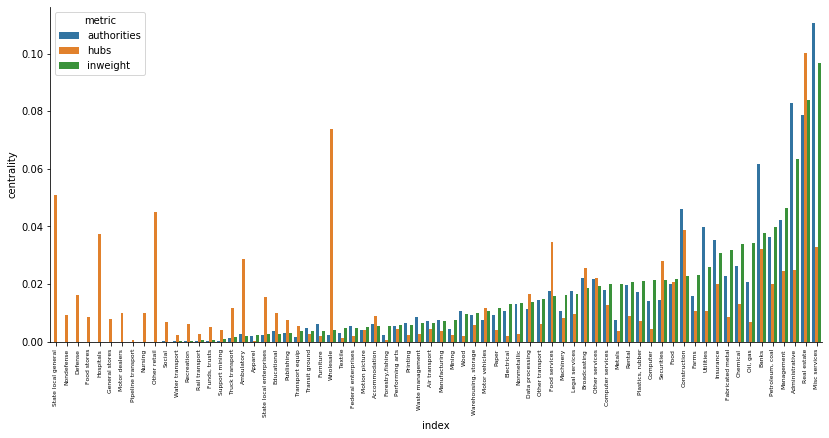

In [13]:
    print(np.round(flows.corr(),2))
    bars = DataFrame()
    for metric in ['authorities','hubs', 'inweight']:
        bar = flows[metric].reset_index().rename(columns = {metric : 'centrality'})
        bar['metric'] = metric
        bars = bars.append(bar, ignore_index=True)
    sns.catplot(x='index', y='centrality', hue='metric', data=bars, kind='bar',
                height=6, aspect=2, legend_out=False,     # size : height, aspect, legend_out                
                order=flows[metric].sort_values().index)  # order industries by inweight                     
    plt.xticks(rotation=90, fontsize=6)
    plt.subplots_adjust(bottom=0.2)

### Print top 3 authorities of 1947, and compare to 2018 graphs, using 1947 scheme

Top authorities in 1947 :
Farms             0.667386
Transportation    0.056163
Wholesale         0.051980
dtype: float64


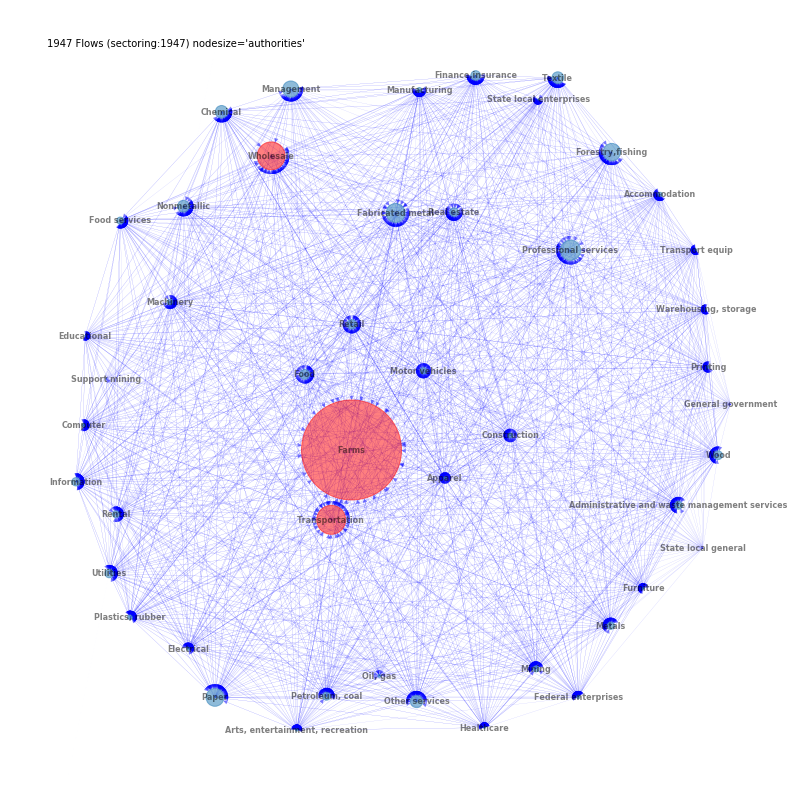

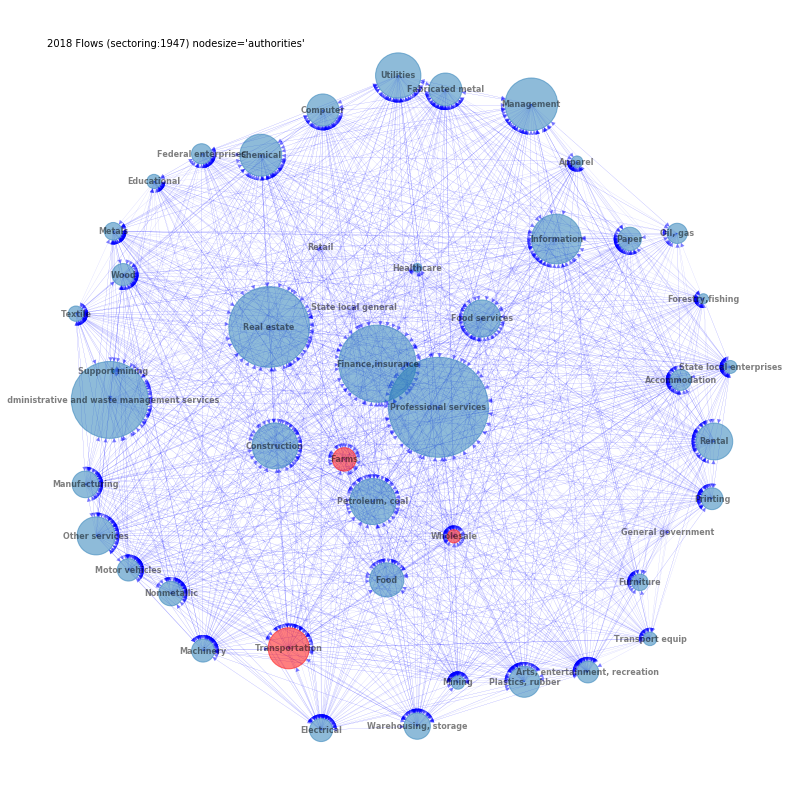

In [11]:
    vintage = 1947          # sectoring scheme fixed at year 1947                                            
    metric = 'authorities'  # rank by this metric                                            
    n = 3
    ranked = DataFrame()
    for year in np.arange(1947, 2019):
        df = ioUses.match(vintage=vintage, year=year)['ioUse']  # apply 1947 sectoring to each year's flow   
        dg = ioUse_graph(df)                                    # make directed network graph                
        calc = graph_calc(dg)                                   # calculate centrality statistics            
        ranked[year] =  pd.Series(calc[metric])                 # rank nodes by metric                       
        ranked['rank' + str(year)] = ranked[year].rank(ascending=False)
        if year == 1947:
            top_nodes = sort_values(calc[metric], reverse=True, items=False)[:n]  # top n nodes              
            print('Top', metric, 'in', year, ':')
            print(pd.Series(calc[metric])[top_nodes])
        if year in [1947, 2018]:
            graph_draw(dg,
                       center = top_nodes[0],     # center graph at the top node from 1947                   
                       nodelist = top_nodes,      # color top n nodes from 1947                              
                       nodesize = calc[metric],   # node size is current year's metric value                 
                       title = "{} Flows (sectoring:{}) nodesize='{}'".format(year, vintage, metric))


### Print 3 biggest change in relative ranks 1947-2018.                                                  
Observed peak at 2006, then several chaotic year through 2011

                        1947    2018  rank1947  rank2018
Warehousing, storage  0.0001  0.0114      43.0      20.0
Construction          0.0016  0.0343      29.0       8.0
Computer              0.0007  0.0169      34.0      17.0


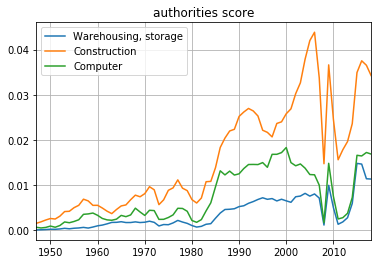

In [12]:
    df = -(ranked['rank2018'] - ranked['rank1947']).sort_values()
    nodes = list(df.iloc[:n].index) #+ list(df.iloc[-n:].index)                                              
    print(np.round(ranked.loc[nodes, [1947, 2018, 'rank1947','rank2018']], 4).to_string())
    df = ranked.loc[nodes, np.arange(1947, 2019)].T    # ['rank' + str(y) for y in np.arange(1947, 2019)]    
    df.plot(kind='line', title=metric + ' score', grid=True)


### Load stock returns, and compute BEA industry own momentum and cross-momentum    
cross-momentum is flow-weighted average of user (or maker) industry returns last month


In [14]:
    rebalbeg, rebalend = 19490101, 20190630
    naics_from_sic = Sectoring('naics', sql)   # maps from sic to naics code                                 

    out = DataFrame()
    prev = 0            # previous beayear loaded                                                            
    for pordate in bd.endmo_range(rebalbeg, rebalend):
        beg = bd.endmo(pordate, -6)
        start = bd.shift(beg, 1)

        # use flows from two years prior, and prevailing sectoring scheme (e.g. bea1947, bea1963 etc)        
        beayear = (pordate//10000) - 2
        if beayear != prev:
            prev = beayear
            ioUse = bea.load_ioUse(beayear)
            if beayear > 1997:
                beayear = 1997
            elif beayear > 1963:
                beayear = 1963
            else:
                beayear = 1947
            bea_from_naics = Sectoring('bea{}'.format(beayear), sql)

        # get crsp universe stocks' past return, and naics code (for bea sectoring)                          
        df = crsp.get_universe(pordate)
        df['weight'] = crsp.get_cap(beg).reindex(df.index)
        df['ret'] = crsp.get_ret(start, pordate).reindex(df.index)
        f = ~df['naics'].gt(0)                             # if naics missing, guess from sic code           
        df.loc[f, 'naics'] = naics_from_sic.find(df.loc[f, 'siccd'])
        df['bea'] = bea_from_naics.find(df['naics'])       # assign bea code from naics                      
        df = df[df['weight'].gt(0) & df['ret'].notnull() & df['bea'].notnull()]  # drop missing rows         
        # compute bea industry return as 'beamom'                                                            
        group = df.groupby(df['bea'])
#        df['ret'] *= df['weight']              # 'bearet' is stocks' weighted industry return               
#        rets = DataFrame(group['ret'].sum() / group['weight'].sum(), columns=['bearet'])                    
        rets = DataFrame(group['ret'].mean()).rename(columns={'ret':'beamom'})  # eql-wtd industry return    

        # merge into ioUse table: user (colcode) and maker (rowcode) industry returns                        
        result = ioUse.join(rets.rename(columns = {'beamom':'maker'}),
                            on='rowcode',
                            how='left')
        result = result.join(rets.rename(columns={'beamom':'user'}),
                             on='colcode',
                             how='left')
        result = result[result['user'].notnull() &
                        result['maker'].notnull() &
                        result['datavalue'].ge(0)]

        # compute flow-weighted user (sum user, by rowcode) and maker (sum maker, by colcode) momentum       
        result['user'] = result['user'] * result['datavalue']
        group = result.groupby(result['rowcode'])   # groupby rowcode (maker), so colcodes are its users     
        rets['user'] = group['user'].sum() / group['datavalue'].sum()

        result['maker'] = result['maker'] * result['datavalue']
        group = result.groupby(result['colcode'])   # groupby colcode (user), so rowcodes are its makers     
        rets['maker'] = group['maker'].sum() / group['datavalue'].sum()

        # merge maker, user and own beamom industry returns into stocks df by 'bea' code                     
        df = df.join(rets, on='bea', how='left')

        # append DataFrame['index','date','bearet','customer','supplier']                                    
        df['rebaldate'] = pordate
        out = out.append(df[['rebaldate','beamom','user','maker']].reset_index(), ignore_index=True)
        print('{} rows for {}'.format(len(df), pordate))

    out = out.rename(columns={'index':'permno'})
    print('{} unique dates, {} records'.format(len(np.unique(out['rebaldate'])), len(out)))


846 unique dates, 3171321 records


### Run backtests with the three forms of industry momentum

In [ ]:
    outdir = ''
    html = ''
    saved = dict()
    benchnames = ['Mom(mo)','Mkt-RF(mo)']
    rebalbeg, rebalend = 19490101, 20190630
    for signal in ['maker','user','beamom']:
        saved[signal] = run_backtest(backtest, crsp, signal, 0, benchnames, rebalbeg, rebalend,
                                     data=out, outdir=outdir, html=html)


(portfolio_sorts)  False


In [32]:
cutoff = 0.08
cm = confusion_matrix(readmission_bin['Readmission_Status'], predsprobit  > cutoff)
no_intervention_cost =  25 * sum(readmission_bin['Readmission_Status'] == 1)
full_intervention_cost = 2 * len(readmission_bin)
modified_cost = cm[0,1] * 2 + cm[1,1] * 2 + cm[1,0] * 25
print([no_intervention_cost, full_intervention_cost, modified_cost])


[210225, 133552, 106002]
